# Sentiment Analysis with Bi-directional LSTM & Attention

In this tutorial we will carry out Sentiment Analysis on 1,600,000 tweets extracted using the Twitter API . The tweets have been annotated as 0 = negative and 4 = positive. For additional information on the dataset please visit following [link](http://help.sentiment140.com/home)

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re
from wordcloud import WordCloud

# print Tensorflow Version
print(f'Tensorflow version: {tf.__version__}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Tensorflow version: 2.2.0


In [2]:
# download the dataset
!wget https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

--2020-06-18 21:49:13--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  2.18MB/s    in 19s     

2020-06-18 21:49:32 (4.19 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [3]:
# unzip the file
!unzip '/content/trainingandtestdata.zip'

Archive:  /content/trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [2]:
# define column width
pd.set_option('display.max_colwidth',300)

# name the columns and define encoding to be used for reading the data
df_columns = ["sentiment", "ids", "date", "query", "user", "text"]

twt = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names=df_columns)

In [3]:
# check the data
twt.head()

,sentiment,ids,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [4]:
# Drop "ids", "date", "query", "user" columns are they are not required
twt = twt.drop(columns=["ids", "date", "query", "user"])

In [5]:
# verify if the columns have been dropped
twt.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
# check dataset info
twt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [ ]:
# check total number of unique values
twt['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [ ]:
# check for null values in our data
twt.isnull().sum()

sentiment    0
text         0
dtype: int64

In [6]:
# map 'Positive' and 'Negative' labels
label_map = {0:'Negative', 4:'Positive'}

def label_decoder(label):
    return label_map[label]

twt['sentiment'] = twt['sentiment'].apply(lambda x: label_decoder(x))
twt.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


Text(0.5, 1.0, 'Sentiment Data Distribution')

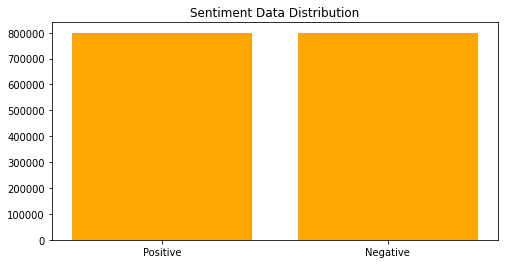

In [ ]:
# check out sentiment distribution
plt.figure(figsize=(8,4))
plt.bar(twt.sentiment.value_counts().index, twt.sentiment.value_counts().values, color='orange')
plt.title("Sentiment Data Distribution")

In [7]:
# preprocess textual data
stop_words = set(stopwords.words('english'))
#stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

text_cleaning_re = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', text.lower(), re.UNICODE)
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if  not word in stop_words]
    text = " ".join(text)
    return text

twt.text = twt.text.apply(lambda x: preprocess(x))

In [8]:
# check preprocessed data
twt.text.head(10)

0                              awww bummer shoulda get david carr third day
1    upset update facebook texting might cry result school today also blah 
2                           dive many time ball manage save 50 rest go bind
3                                          whole body feel itchy like fire 
4                                                           behave mad see 
5                                                               whole crew 
6                                                                 need hug 
7                      hey long time see yes rain bite bite lol fine thank 
8                                                                     nope 
9                                                                que muera 
Name: text, dtype: object

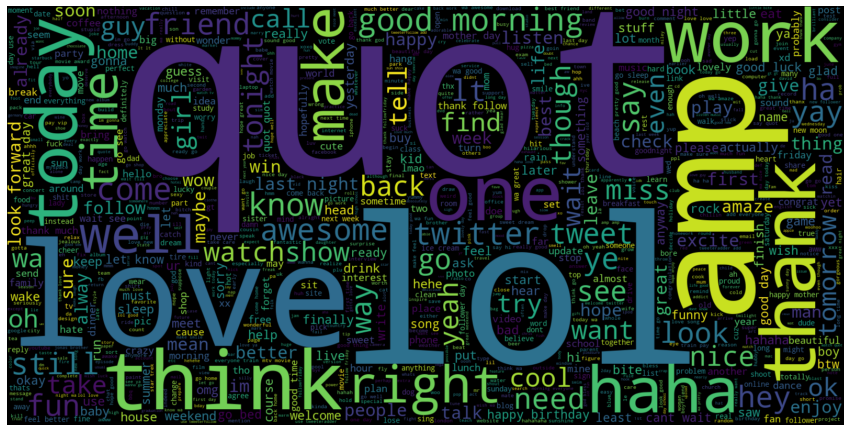

In [23]:
# word cloud for positive words
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(' '.join(twt[twt.sentiment == 'Positive'].text))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

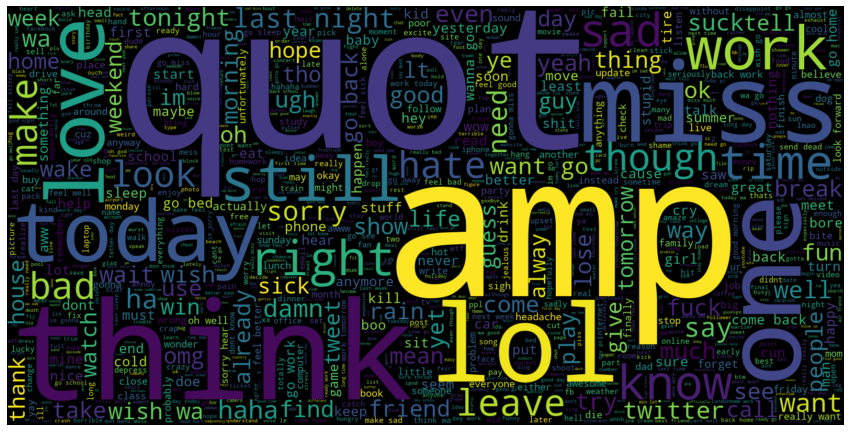

In [24]:
# word cloud for negative words
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(' '.join(twt[twt.sentiment == 'Negative'].text))
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

In [9]:
# do train test split
train_data, test_data = train_test_split(twt, test_size=0.2)

print(f'Training Data Size: {len(train_data)}')
print(f'Testing Data Size: {len(test_data)}')

Training Data Size: 1280000
Testing Data Size: 320000


__We did not do 'fit_on_texts' on 'test_docs' as it uses the vocab learned from the training data to index words in test. If there are new words, they are marked as zero.__

In [10]:
# tokenize the text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_data.text)

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 270945


In [11]:
# encode training and testing data
train_encoded_data = tokenizer.texts_to_sequences(train_data.text) 
test_encoded_data = tokenizer.texts_to_sequences(test_data.text)

# pad sequences on encoded training and testing data
max_length = max([len(t.split()) for t in train_data.text])
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_encoded_data, maxlen=max_length, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_encoded_data, maxlen=max_length, padding='post')

# get shape of the data
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')

X_train Shape: (1280000, 36)
X_test Shape: (320000, 36)


In [12]:
# encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train_data.sentiment.to_list())

y_train = label_encoder.transform(train_data.sentiment.to_list())
y_test = label_encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# get shape of labels
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

y_train Shape: (1280000, 1)
y_test Shape: (320000, 1)


## [Attention Mechanism](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)

In [13]:
# define Attention
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
  
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [30]:
# define the model
inputs = tf.keras.layers.Input(shape=(max_length,))
embeddings = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=300)(inputs)
lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True, dropout=0.4))(embeddings)
(lstm_2, fwd_hidden_state, fwd_cell_state, bkwrd_hidden_state, bkwrd_cell_state) = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True, return_state=True, dropout=0.4))(lstm_1)
hidden_state = tf.keras.layers.Concatenate()([fwd_hidden_state, bkwrd_hidden_state])
cell_state = tf.keras.layers.Concatenate()([fwd_cell_state, bkwrd_cell_state])
#lstm_1 = tf.keras.layers.LSTM(units=512, return_sequences=True)(embeddings)
#lstm_2, hidden_state, cell_state = tf.keras.layers.LSTM(units=512, return_sequences=True, return_state=True)(lstm_1)
context_vector, attention_weights = Attention(units=256)(lstm_2, hidden_state)
dense = tf.keras.layers.Dense(units=256, activation='relu')(context_vector)
dropout = tf.keras.layers.Dropout(0.5)(dense)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(dropout)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 36)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 300)      81433800    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 36, 512)      1140736     embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 36, 512), (N 1574912     bidirectional[0][0]              
______________________________________________________________________________________________

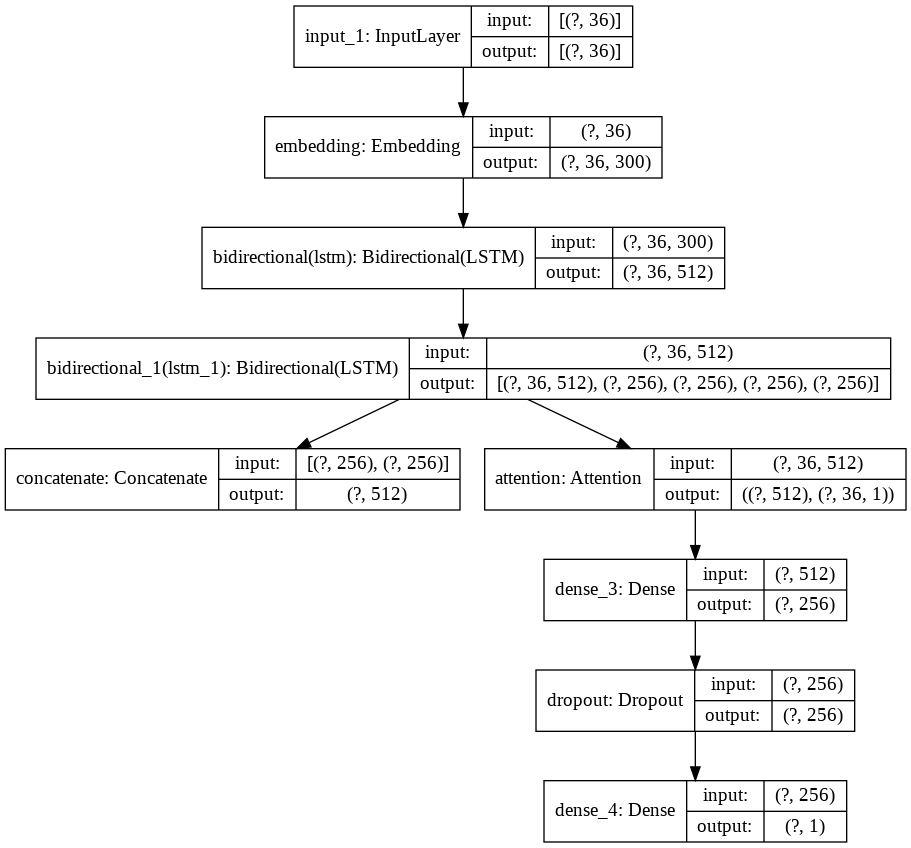

In [31]:
# plot the model
tf.keras.utils.plot_model(model, to_file='txt_attn.png', show_shapes=True)

In [16]:
# compile the network
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# define model checkpoint
#mckpt = tf.keras.callbacks.ModelCheckpoint('txt_rnn_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [33]:
# fit the network
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=2048, callbacks=[es])

Epoch 1/10
625/625 [==============================] - 827s 1s/step - loss: 0.4876 - accuracy: 0.7606 - val_loss: 0.4585 - val_accuracy: 0.7805
Epoch 2/10
625/625 [==============================] - 823s 1s/step - loss: 0.4303 - accuracy: 0.7991 - val_loss: 0.4569 - val_accuracy: 0.7835
Epoch 3/10
625/625 [==============================] - 825s 1s/step - loss: 0.3945 - accuracy: 0.8191 - val_loss: 0.4713 - val_accuracy: 0.7818
Epoch 4/10
625/625 [==============================] - 827s 1s/step - loss: 0.3607 - accuracy: 0.8365 - val_loss: 0.4982 - val_accuracy: 0.7780
Epoch 5/10
625/625 [==============================] - 825s 1s/step - loss: 0.3289 - accuracy: 0.8501 - val_loss: 0.5323 - val_accuracy: 0.7755
Epoch 00005: early stopping


In [34]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 92s 9ms/step - loss: 0.5323 - accuracy: 0.7755


In [35]:
# print accuracy on test dataset
print(f'Test Accuracy : {accuracy*100:.2f}')

Test Accuracy : 77.55


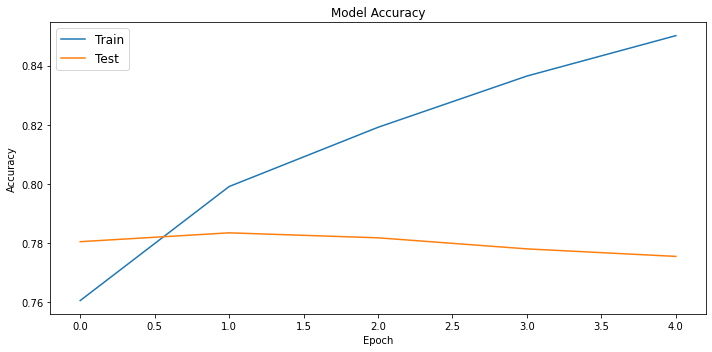

In [36]:
# Plot Model Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(labels=['Train', 'Test'], fontsize='large')
plt.tight_layout()

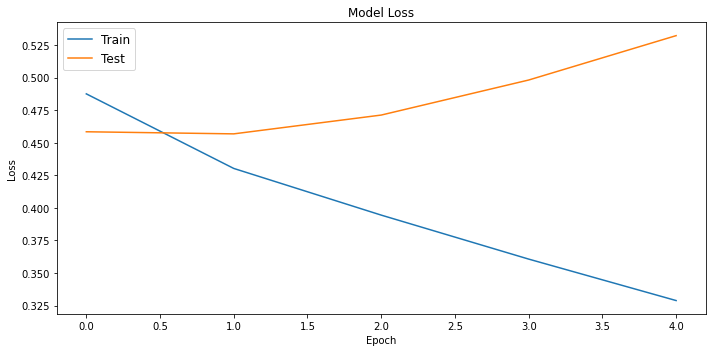

In [37]:
# Plot Model Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(labels=['Train', 'Test'], fontsize='large')
plt.tight_layout()

[Text Classification with RNN](https://www.tensorflow.org/tutorials/text/text_classification_rnn)

[Bidirectional LSTM on IMDB](https://keras.io/examples/nlp/bidirectional_lstm_imdb/)

[Text Classification using LSTM](https://www.kaggle.com/arunrk7/nlp-beginner-text-classification-using-lstm)

[Attention for Text Classification](https://matthewmcateer.me/blog/getting-started-with-attention-for-classification/)

[Text Classification using Attention Mechanism in Keras](https://androidkt.com/text-classification-using-attention-mechanism-in-keras/)

[Best Practices for Text Classification with Deep Learning](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/)